In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

/home/merlinuser/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/merlinuser/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import random, re, time
from datetime import datetime

# Introduzione Pyspark 
<!-- requirement: small_data/employee -->
<!-- requirement: small_data/gutenberg -->
<!-- requirement: small_data/eeg -->
<!-- requirement: scripts/namenode-reset.sh -->
Come _Hadoop_, __Spark__ è un framework di computo distribuito su un cluster di calcolatori. Rispetto ad _Hadoop_ ha due vantaggi notevoli:
 
 - Può effettuare il _caching_ in memoria tra gli step di computazione, mentre _Hadoop_ per sua natura scrive su disco, con miglioramento importante delle performance. Questo vantaggio è ancora più evidente per quelle classi di algoritmi che sono lenti by design e che richiedono un uso pesante della cache (ad esempio algoritmi iterativi, molto utilizzati nell'ambito del training di modelli di machine learning)
 - Si adatta in maniera flessibile a varie tipologie di calcolo (non solo MapReduce).
 
Altro vantaggio è la facilità con cui è possibile interfacciarsi con le API di base soprattuto se comparate alla scrittura di codice MapReduce. Il linguaggio principale è _Scala_ basato su JVM, ma esiste un buon supporto anche per Python.  

### Riferimenti

* [Spark homepage](http://spark.apache.org) è il punto di partenza per avere informazioni e dettagli su API, guide di programmazione, e in generale le maggior parte delle cose di cui avrai bisogno in qualità di programmatore Spark.
* [GitHub page](https://github.com/apache/spark) utile per navigare all'interno del codice sorgente.
* [DataBricks Community Edition](https://community.cloud.databricks.com) è una sandbox Spark messa a disposizione dai creatori del prodotto, piena di tutorial e esempi interattivi di programmazione.
* Il gitbook completo [Mastering Apache Spark 2.0](https://www.gitbook.com/book/jaceklaskowski/mastering-apache-spark/details).

## Come si relaziona Spark con Hadoop?  

__Risposta 1__: È un sostituto. Si può mettere in piedi e gestire il proprio cluster Spark, independentemente da Hadoop. Tuttavia la definizione di un filesystem condiviso dal cluster va gestita a parte. (In questo contesto, _Spark SQL_ è il rimpiazzo per _Hive_, per operazioni SQL-like.)

__Risposta 2__: È un complemento. Si può far girare Spark on top su un cluster Hadoop, e sfruttare HDFS e YARN -- In questo caso Spark è solo un sostituto di MapReduce.  (In questo contesto, _Spark SQL_ può essere utilizzato in maniera alternativa ad _Hive_ oppure on top.)

## Le API di Spark
### Sostantivi

Le due principali astrazioni di Spark sono:

1. Resilient distributed datasets (RDD):
  Si tratta di liste distribuite di oggetti, partizionate tra i nodi del cluster su cui si può lavorare in parallelo. Le operazioni che si possono effettuare prendono la forma di funzioni applicate agli elementi delle liste, oggetto dell'analisi. Esistono due tipi di operazioni: Trasformazioni e Azioni.

2. Variabili _shared_ condivise in operazioni effettuate in parallelo: quando Spark applica un funzione in parallelo su i nodi del cluster, porta con sé una copia di ciascuna variabile richiesta dalla funzione, su ciascun nodo. Per ridurre l'incoveniente di ripetere più volte l'operazione di copia di una stessa variabile, esistono due tipi di variabili _shared_:
 - Variabili di Broadcast: Utilizzate per depositare in memoria il valore di una certa variabile su tutti i nodi worker (difatti il nodo driver effettua un "broadcast" su i nodi lavoratori).
 - Accumulatori: si tratta di variabili di "accumulo" utilizzate per implementare somme e contatori tra i nodi lavoratori.
 
### Verbi
- **Transformazioni:** Definiscono un nuovo RDD a partire da uno preesistente: ad esempio `map` oppure `flatMap`. Le trasformazioni in Spark sono __lazy__, ovvero la trasformazione non viene applicata al momento dell'invocazione a runtime ma solamente quando l'output della trasformazione è richiesto da qualche altra funzione.  In particolare, ciò significa che i risultati intermedi del computo non sono necessariamente salvati da qualche parte -- se ad esempio all'output di una `map` viene applicata una `reduce`, Spark dovrebbe essere in grado di capire che il risultato intermedio della map non deve essere salvato in memoria in quanto la richiesta finale è la `reduce` del dato. Una conseguenza di questo design è che gli output delle trasformazioni sono per default ricalcolati ogni volta che vengono richiesti. Per evitare ciò bisogna esplicitamente invocare il metodo `cache` oppure `persist`.
    
    [Transformazioni](https://spark.apache.org/docs/latest/rdd-programming-guide.html#transformations) tipicamente *transformano* il dato e ritornano un altro RDD. Esistono due tipologie: le trasformazioni base e quelle chiave-valore. Esempi di trasformazioni base includono `map`, `filter`, `flatMap`, esempi di trasformazioni chiave-valore includono invece `join`, `cogroup`, `groupByKey`, `reduceByKey`, `countByKey`, e `sample`.


- **Azioni:** Di base ritornano un valore come risultato finale di un computo. Ad esempio `reduce` è un' azione che combina tutti gli elementi di un RDD tramite una data funzione per poi ritornare il risultato finale della combinazione.  (Nota che invece `reduceByKey` è una trasformazione e quindi alla fine ritorna un RDD.)
    
    [Azioni](https://spark.apache.org/docs/latest/rdd-programming-guide.html#actions) generano tipicamente output *contenuti* (e.g. `reduce`, `count`, `first`, `take`, `takeSample`, `foreach`, `collect`) oppure persistono il dato su disco (`saveAsTextFile`, `saveAsSequenceFile`, etc.).


## Definire uno Spark Context

#### Premessa
Prima di procedere ad applicare trasformazioni ed azioni sui nostri dati occorre assicurarsi che la libreria `pyspark` sia visibile nel contesto python attualmente in uso ( è sufficiente impostare la variabile di sistema `PYTHONPATH` per specificare librerie locate in path custom come nel nostro caso ). Una volta verificato questo prerequisito possiamo procedere alla definizione di un contesto Spark locale, passando in fase di definizione i metadati e le configurazioni desiderate.  

In [3]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setMaster("local[*]").setAppName("01_Python_API")
sc = SparkContext(conf = conf)
print(sc.version)

# o in alternativa
# sc = SparkContext("local[*]", "01_Python_API")
# print(sc.version)

2.2.1


Con i comandi sopra abbiamo definito nel nostro SparkContext, la URL del master che in questo caso è un'instanza locale Spark e il nome associato all'instanza `"01_Python_API"`. Con la sintassi `local[*]` si intende che tale instanza locale utilizzerà tutti i core disponibili sul server. Contestualmente all'avvio di Spark, anche la web UI relativa è disponibile a questo [indirizzo](http://localhost:4040). 

In generale le URL master ammesse da Spark sono elencate [qui](https://spark.apache.org/docs/latest/submitting-applications.html#master-urls).

## Spark examples

#### Premessa
L'esempio classico per chi inizia a programmare in Spark è la lettura di un file di testo e il successivo raggruppamento e/o filtro sulle parole del testo, per poi salvare il risultato su disco o altro supporto.

Nell' esempio viene proposto la lettura di file di testo contenuti nel path locale `small_data/gutenberg`

```
The Project Gutenberg EBook of The Outline of Science, Vol. 1 (of 4), by 
J. Arthur Thomson

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: The Outline of Science, Vol. 1 (of 4)
       A Plain Story Simply Told

Author: J. Arthur Thomson

Release Date: January 22, 2007 [EBook #20417]

Language: English
...
```

A questo punto vogliamo calcolare il numero di ricorrenze di una stessa parola e quindi salvare il risultato su disco

In [4]:
import os
def localpath(path):
    return 'file://' + str(os.path.abspath(os.path.curdir)) + '/' + path

In [5]:
lines = sc.textFile(localpath('small_data/gutenberg/'))
totalLines = lines.count()
print("total lines: %d" % totalLines)

total lines: 77931


Una volta letti i file di testo nella cartella `small_data/gutenberg` viene invocata l'azione `count` che fornisce il totale delle righe lette. In questo caso `TextFile` è una trasformazione che genera RDD `lines` ,   `count` è l'azione restituisce il risultato finale. Ora vogliamo calcolare il numero di occorrenze di una stessa parola all'interno di `lines`:

In [6]:
lines.flatMap(lambda line: line.split(" ")) \
    .map(lambda word: (word.lower(), 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .sortByKey() \
    .saveAsTextFile("file:///tmp/output_gutenberg" + str(time.time()))

Il RDD `lines` viene processato da una serie di trasformatori che elaborano i file di testo, ritornando alla fine una lista di tuple che contengono la singola parola e in numero di occorrenze totali della stessa all'interno dei files. L'esecuzione delle trasformazioni viene invocata solamente alla fine in presenza dell'azione `saveAsTextFile`. Per verificare il risultato aprire una shell e accedere alla cartella `/tmp/output_gutenberg*`.

Si noti anche come delle funzioni anonime (lambda) vengano passate come argomento delle API di Spark.

**Esercizio:** Nell'output generato negli step precedenti vi sono molti caratteri speciali. Come procedereste se vi chiedessero di contare solamente le parole che contegono solo caratteri alfabetici?  (Suggerimento) In Python un modo per testare i caratteri delle parole è il seguente:

In [12]:
filteredTotalCount = lines.flatMap(lambda line: line.split(" ")) \
    .filter(lambda word: re.search("^[a-zA-Z]+$", word)) \
    .count()
print("total filtered words: %d" % filteredTotalCount)

total filtered words: 517963


In [11]:
matches = re.search("^[a-zA-Z]+$", "abc")
matches.group(0)

'abc'

## ETL in Spark

#### Premessa
All'interno di un qualunque progetto di data science i primi steps comprendono una fase di ETL e di analisi esplorativa sul dataset.
Di seguito familizzeremo con la Spark shell e le api che ci permettono di raggiungere questo scopo.

#### il dataset
Preso da UC Irvine [Machine Learning Archive](http://cml.ics.uci.edu/):
> "The first four lines are header information. Line 1 contains the subject identifier and indicates if the subject was an alcoholic (a) or control (c) subject by the fourth letter. Line 4 identifies the matching conditions: a single object shown (S1 obj), object 2 shown in a matching condition (S2 match), and object 2 shown in a non matching condition (S2 nomatch). Line 5 identifies the start of the data from sensor FP1. The four columns of data are: the trial number, sensor position, sample number (0-255), and sensor value (in micro volts)."

Esistono 16,452 righe in questo file incluso l'header (sono 30 files uguali). Sotto un estratto delle prime 10 linee e delle ultime 10:
```
# co2a0000364.rd
# 120 trials, 64 chans, 416 samples 368 post_stim samples
# 3.906000 msecs uV
# S1 obj , trial 0
# FP1 chan 0
0 FP1 0 -8.921
0 FP1 1 -8.433
0 FP1 2 -2.574
0 FP1 3 5.239
0 FP1 4 11.587
    ...
0 Y 246 24.150
0 Y 247 20.243
0 Y 248 11.454
0 Y 249 4.618
0 Y 250 3.153
0 Y 251 6.571
0 Y 252 12.431
0 Y 253 15.849
0 Y 254 16.337
0 Y 255 14.872
```


#### Statistiche descrittive del dataset

1. Esiste un'azione `RDD[Double]` chiamata `stats` che ritorna le statistiche riassuntive relative di un RDD. Come possiamo ottenere le statistiche riassuntive della sola colonna `reading` nell'intero dataset?

2. Come possiamo fare la stessa cosa per `posn` uguale a "FP1"?

3. Dobbiamo assicurarci che esistano solo 256 campioni per ciascun `posn` nel dataset. Come possiamo farlo? 

Definiamo le classi e le funzioni che ci permetteranno di transformare in oggetti i record del dataset. Si noti come nel `map` finale stavolta abbiamo passato una funzione standard e non una funzione anonima.

In [13]:
def isHeader(line):
    return "# " in line

class Record(object):
    def __init__(self, trial, posn, sample, reading):
        self.trial = trial
        self.posn = posn
        self.sample = sample
        self.reading = reading

def parse(line):
    tokens = line.split()
    trial = int(tokens[0])
    posn = tokens[1]
    sample = int(tokens[2])
    reading = float(tokens[3])
    return Record(trial, posn, sample, reading)

data = sc.textFile(localpath("small_data/eeg/*")) \
    .filter(lambda x: not isHeader(x)) \
    .map(parse)

Per rispondere al primo quesito selezioniamo la sola colonna reading

In [20]:
print(data.map(lambda x: x.reading).stats())

AttributeError: 'list' object has no attribute 'stats'

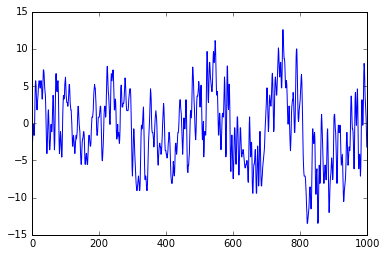

In [17]:
matplotlib.pyplot.plot(data.map(lambda x: x.reading).take(1000))

Per il secondo quesito filtriamo in base al parametro richiesto

In [24]:
print(data.filter(lambda x: x.posn == "FP1").map(lambda x: x.reading).stats())

(count: 7680, mean: 0.8176342447916662, stdev: 8.41845604122, max: 27.649, min: -25.513)


Per rispondere al terzo quesito raggruppiamo per tipologia di `trial` e `posn`

In [25]:
samples = data.map(lambda record: ((record.trial, record.posn), 1)).reduceByKey(lambda a, b: a + b)
posns = samples.map(lambda record_key_count: (record_key_count[0][1], record_key_count[1])).distinct()

assert posns.take(1)[0][1] == 256
assert posns.count() == posns.filter(lambda x: x[1] == 256).count()

**Esercizio:** Come verifichiamo che la somma dei campioni fa il totale dei record (491520 campioni)?

In [26]:
assert data.count() == samples.map(lambda record_key_count: record_key_count[1]).reduce(lambda x, y: x + y)

## Join in Spark

In MapReduce una join viene calcolata a partire da record in formato chiave-valore`(k, v)`. Questi record vengono associati tra loro in base ad una chiave comune. In Spark il meccanismo è analogo a quello di MapReduce (in quanto Spark distribuisce i record aventi chiavi comuni negli stessi *nodi*). La differenza è che in Spark, le coppie chiave-valore non devono essere necessariamente salvate su disco.

Nell'esempio sottostante abbiamo due dataset in formato csv [`users.csv`](small_data/employee/users.csv) e [`sales.csv`](small_data/employee/sales.csv). Nel primo abbiamo la lista degli utenti che hannp fatto degli acquisti mentre nel secondo vengono elencate le transazioni effettuati dagli utenti. A questo punto vogliamo calcolare:

1. Qual è il totale delle vendite?
2. Quanti utenti per ogni country?

In [29]:
class Transaction(object):
    def __init__(self, transactionId, productId, userId, amount):
        self.transactionId = transactionId
        self.productId = productId
        self.userId = userId
        self.amount = int(amount)

class User(object):
    def __init__(self, userId, email, language, country):
        self.userId = userId
        self.email = email
        self.language = language
        self.country = country

def construct_user(line):
    data = line.split(",")
    return User(data[1], data[2], data[3], data[4])

def construct_transaction(line):
    data = line.split(",")
    if data[0] == "sales":
        return Transaction(data[1], data[2], data[3], data[4])
    else:
        return None

users = sc.textFile(localpath("small_data/employee/users.csv")) \
    .map(construct_user)

transactions = sc.textFile(localpath("small_data/employee/sales.csv")) \
    .map(construct_transaction)
    
# totalSales = ?
# usersByCountryCount = ?

**Esercizio**: Calcola tu il valore del `totalSales` e `usersByCountryCount`

In [30]:
totalSales = transactions.filter(lambda x: x is not None).map(lambda x: x.amount).sum()
usersByCountryCount = users.map(lambda u: (u.country, u)).countByKey()

print("total sales %f" % totalSales)
print("Users by country")
for key, val in usersByCountryCount.items():
    print (key, val)

total sales 700.000000
Users by country
GB 1
US 1
FR 2


A questo questo calcoliamo il totale delle vendite per country tramite la chiave in comune `userId` e ne stampiamo il valore a video

In [31]:
# This is (userId, (transaction, user))
salesByCountry = transactions.filter(lambda x: x is not None) \
                .map(lambda t: (t.userId, t.amount)) \
                .join(users.map(lambda u: (u.userId, u.country))) \
                .map(lambda id_amount_country: (id_amount_country[1][1], id_amount_country[1][0])) \
                .reduceByKey(lambda x, y: x + y ) \
                .collect()

print("Transactions by country")
for country in salesByCountry:
    print(country[0], country[1])

Transactions by country
FR 150
US 400
GB 150


**Esercizio**: e se volessi la lista dei `productId` per country?

In [32]:
productsByCountry = transactions.filter(lambda x : x is not None) \
                     .map(lambda t: (t.userId, t.productId)) \
                     .join(users.map(lambda u: (u.userId, u.country))) \
                     .map(lambda id_product_country: (id_product_country[1][1], id_product_country[1][0])) \
                     .map(lambda country_product: (country_product[0], [country_product[1]])) \
                     .reduceByKey(lambda x, y: x + y)  \
                     .collect()

print("Products by country")
for country in productsByCountry:
    print(country[0], country[1])

Products by country
FR ['product4', 'product1']
US ['product1', 'product3', 'product2']
GB ['product4']


### Riepilogo principali trasformazioni e azioni
Fonte: `Zaharia M., et al. Learning Spark (O'Reilly, 2015)`

#### Transformazioni di base
Transformazioni basiche applicate ad un RDD contenente `{1, 2, 3, 3}`
<img src="images/Basic_transf_1.png" width="55%">

Transformazioni basiche applicate a coppie di RDD rispettivamente contenenti  `{1, 2, 3}` e `{3, 4, 5}`
<img src="images/Basic_transf_2.png" width="55%">

#### Transformazioni coppia chiave-valore
Transformazioni chiave-valore applicate RDD contenente `{(1, 2), (3, 4), (3, 6)})`
<img src="images/Basic_transf_KV_1.png" width="55%">
<img src="images/Basic_transf_KV_2.png" width="55%">
 
Transformazioni chiave-valore applicate a coppie di RDD rispettivamente contenenti  ` {(1, 2), (3, 4), (3, 6)} ` e `{(3, 9)}`
<img src="images/Basic_transf_KV_3.png" width="55%">
#### Azioni
Azioni basiche applicate ad un RDD contenente `{1, 2, 3, 3}`
<img src="images/Basic_actions_1.png" width="55%">
<img src="images/Basic_actions_2.png" width="55%">



### Persistenza di un RDD
Quando si persiste un RDD, ciascun nodo salva in memoria tutte le partizioni  che lo compongono e le riusa per altre azioni nel dataset (o nei dataset derivati). Ciò permette di velocizzare eventuali azioni successive applicate allo stesso RDD.

L'argomento passato alla funzione `persist` determina il metodo con cui Spark salverà il RDD. In generale, si può scegliere tra:
* Formati deserializzati o serializzati (Oggetti Java serializzati sono molto più efficienti dal punto di vista dello spazio occupato ma molto più intensivi in lettura dal punto di vista della CPU).
* Solo in memoria oppure anche su disco se necessario.
* Fault tolerant tramite ridondanza della partizione.
* [Documentazione completa](http://spark.apache.org/docs/latest/rdd-programming-guide.html#rdd-persistence)


*Serializzazione*: rappresenta il processo di traduzione delle strutture dati o degli stati degli oggetti in un  formato (sequenze di bit) che può essere messo da parte in un primo momento e recuperato in seguito. Nota bene che in Python, il salvataggio degli oggetti è sempre gestito da Pickle, pertanto non c'è distinzione tra serializzato o deserializzato.

1. Il metodo cache è una scorciatoia per il comportamento di default: in memoria and deserializzato:
```python
myRdd.cache()
```
2. Altrimenti è possibile specificare il comportamente desiderato:
```python
from pyspark import storagelevel
myRdd.persist(storagelevel.StorageLevel.MEMORY_ONLY_SER)
```
3. Pulire i dati in cache è importante per la gestione della memoria. Durante i data shuffle, alcuni dati intermedi vengono automaticamente messi in persistenza, quindi può essere conveniente richiamare il metodo `unpersist` manualmente piuttosto che aspettare la garbage collection:
```python
myRDD.unpersist()
```

Nell' esempio sottostante viene generata una lista sufficientemente grande di numeri casuali in Spark. Lo stesso RDD viene assegnato a due variabili. Per la seconda variabile invochiamo la cache esplicitamente. I tempi di esecuzione di una `reduce` nella prima variabile rimangono costanti per ogni iterazione, nella seconda variabile all'aumentare delle iterazioni i tempi convergono ad un limite, molto inferiore rispetto alla prima variabile.

In [33]:
def randomStream():
    return sc.parallelize(range(1,10000001)).map(lambda x: random.random())

uncachedLines = randomStream()
cachedLines = randomStream().cache()

In [34]:
%timeit -n1 -r1 add = uncachedLines.reduce(lambda x, y: x + y)
%timeit -n1 -r1 sub = uncachedLines.reduce(lambda x, y: x - y)
%timeit -n1 -r1 mult = uncachedLines.reduce(lambda x, y: x * y)

1 loop, best of 1: 3.72 s per loop
1 loop, best of 1: 3.56 s per loop
1 loop, best of 1: 3.59 s per loop


In [35]:
%timeit -n1 -r1 add = cachedLines.reduce(lambda x, y: x + y)
%timeit -n1 -r1 sub = cachedLines.reduce(lambda x, y: x - y)
%timeit -n1 -r1 mult = cachedLines.reduce(lambda x, y: x * y)

1 loop, best of 1: 5.52 s per loop
1 loop, best of 1: 2.11 s per loop
1 loop, best of 1: 1.89 s per loop


## Accumulatori

Necessari se si vuole implementare contatori globali tra i nodi lavoratori (come nei job MapReduce e hadoop in generale). Per cominciare un piccolo controesempio:

In [50]:
class Counter(object):
    def __init__(self):
        self.counter = 0
        pass

    def add(self, amt=1):
        self.counter += amt
        pass

counter = Counter()

sc.parallelize(range(1,11)).foreach(lambda x: counter.add(1))

print(counter.counter)  # che sta succedendo?

0


Di seguito il metodo corretto per implementare gli [Accumulatori](https://spark.apache.org/docs/2.2.0/api/scala/index.html#org.apache.spark.Accumulator). In questo caso li stiamo utilizziamo per una somma incrementale di interi.

In [51]:
accumCounter = sc.accumulator(0)
sc.parallelize(range(1,11)).foreach(lambda x: accumCounter.add(x))
print(accumCounter)

55


In [73]:
# Esempio in modalità lazy
# attenzione l'accumulatore non risulta essere solo un buffer statico
# ma applicando una funzione associativa risulta un buffer dinamico
# invocato rispetto al numero di azioni effettuate
def update(x):
    accumCounter.add(1)
    return x

accumCounter = sc.accumulator(0)

myRdd = sc.parallelize(range(1, 11)).map(update)
print("counter: ", accumCounter)

print("reduce:  ", myRdd.reduce(lambda x, y: x + y))
print("counter: ", accumCounter)

myRdd.take(1)
print ("counter: ", accumCounter)

counter:  0
reduce:   55
counter:  10
counter:  11


## Variabili Broadcast

Variabili broadcast sono l'equivalente Spark della cache distribuita di Hadoop: servono a salvare nella cache di ciascun nodo, dei dati in modalità read-only _una tantum_, piuttosto che trasportare insieme ai task una nuova copia dello stesso dato.

In [74]:
# Esempio base:

iBV = sc.broadcast(10)
assert(iBV.value == 10)

Di seguito un esempio più realistico di utilizzo della variabile in broadcast:

In [75]:
class Sale(object):
    def __init__(self, state, sales):
        self.state = state
        self.sales = sales
        
def constructSale(tup):
    return Sale(tup[0], tup[1])

In [86]:
states = {
    0: "AL",
    1: "KY",
    2: "VT",
    3: "NY",
    4: "WY"
}

statesBV = sc.broadcast(states)

data = sc.parallelize([(0, 30.), (1, 40.), (2, 20.), (2, 10.),(3, 20.),(4, 50.)]).map(constructSale)

In [90]:
%%timeit -r1 -n100
# This works but it will send `states` to each node again if run twice
results1 = data.map(lambda s: (states[s.state], s.sales)).collect()

1000 loops, best of 1: 74.9 ms per loop


In [89]:
%%timeit -r1 -n100
# broadcast to each node once, and can be used freely inside map
results2 = data.map(lambda s: (statesBV.value[s.state], s.sales)).collect()

100 loops, best of 1: 79.5 ms per loop


In [91]:
results1 = data.map(lambda s: (states[s.state], s.sales)).collect()
results2 = data.map(lambda s: (statesBV.value[s.state], s.sales)).collect()
assert(results1 == results2)

**Due caveat:**
1. Dopo aver creato la variabile broadcast, la teoria vuole che tale variabile venga utilizzata in maniera privilegiata rispetto alle variabili standard, in modo tale da evitare che il valore della stessa variabile venga trasmesso ai nodi più di una volta.
2. La variabile broadcast non deve essere modificata dopo essere stata trasmessa ai nodi, in modo tale da assicurare che tutti i nodi abbiano lo stesso valore della variabile.

In [92]:
sc.stop()